<a href="https://colab.research.google.com/github/MariMar0112/-/blob/main/VCp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#/content/sample_data/Filtered_DataVCp_All_Columns.xlsx
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Загрузка данных
data = pd.read_excel('/content/sample_data/Filtered_DataVCp_All_Columns.xlsx')
temperature = data['T,K'].values
heat_capacity = data['Cp,J/mol-1K-1'].values

heat_capacity = temperature[temperature>10]
temperature = temperature[temperature>10]

In [8]:
data = np.nan_to_num(data, nan=0, posinf=1e6, neginf=-1e6)

In [ ]:
!pip install pymc

In [9]:
import pymc as pm

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-pac

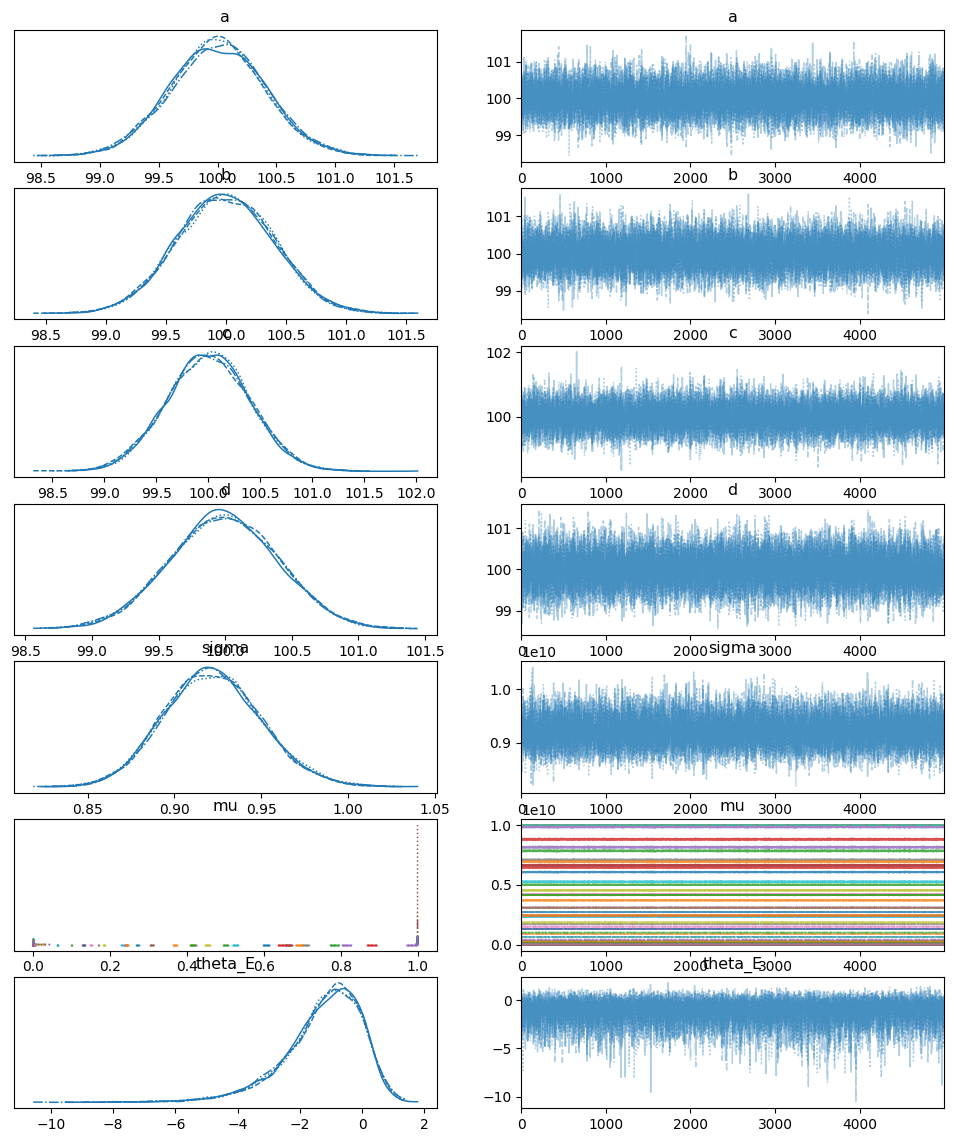

In [10]:
with pm.Model() as model:
    # Априорные распределения
    z = pm.Gamma('z', alpha=1, beta=2)
    theta_E = pm.Deterministic('theta_E', pm.math.log(z))

    # Коэффициенты
    a = pm.Normal('a', mu=100, sigma=0.4)
    b = pm.Normal('b', mu=100, sigma=0.4)
    c = pm.Normal('c', mu=100, sigma=0.4)
    d = pm.Normal('d', mu=100, sigma=0.4)

    # Параметр смешения
    sigma = pm.HalfCauchy('sigma', beta=1)

    # Формула Эйнштейна
    z_pow = z ** (1 / temperature)  # z^(1/T)
    term_E = pm.Deterministic('term_E', (pm.math.log(z) / temperature)**2 * z_pow / (z_pow - 1)**2)

    # Ограничение mu, чтобы избежать переполнения
    mu = pm.Deterministic('mu', pm.math.clip(  # Ограничиваем диапазон mu
            3 * 8.314 * term_E + a * temperature + b * temperature**2 + c * temperature**3 + d * temperature**4,
            -1e10, 1e10
)
    )

    # Правдоподобие
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=heat_capacity)

    trace = pm.sample(draws=5000, tune=3000, chains=4, target_accept=0.95, random_seed=42, nuts={'max_treedepth': 12}, init='adapt_diag')

    az.summary(trace)
    az.plot_trace(trace, var_names=['a', 'b', 'c', 'd', 'sigma', 'mu', 'theta_E' ])  # Только ключевые параметры

In [12]:
with model:
    idata = pm.sample(500, tune=1000, target_accept=0.98)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


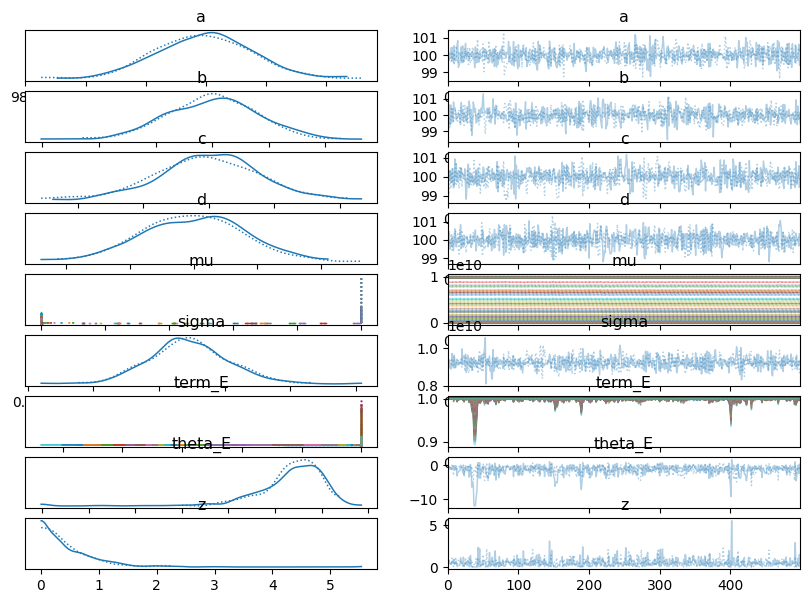

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-pac

                     mean          sd        hdi_3%       hdi_97%  mcse_mean  \
a            9.998700e+01       0.389  9.927700e+01  1.007190e+02      0.011   
b            1.000040e+02       0.399  9.920400e+01  1.006880e+02      0.012   
c            9.999300e+01       0.400  9.923100e+01  1.007750e+02      0.014   
d            9.999300e+01       0.397  9.925800e+01  1.007600e+02      0.011   
mu[0]        9.999945e+09  906122.431  1.000000e+10  1.000000e+10  28456.279   
...                   ...         ...           ...           ...        ...   
term_E[537]  1.000000e+00       0.000  1.000000e+00  1.000000e+00      0.000   
term_E[538]  1.000000e+00       0.000  1.000000e+00  1.000000e+00      0.000   
term_E[539]  1.000000e+00       0.000  1.000000e+00  1.000000e+00      0.000   
theta_E     -1.311000e+00       1.406 -3.626000e+00  7.790000e-01      0.079   
z            4.820000e-01       0.477  0.000000e+00  1.274000e+00      0.013   

                mcse_sd  ess_bulk  ess_

In [13]:
with model:
# Визуализация результатов
    az.plot_trace(idata, figsize=(10, 7))
    plt.show()

    # Вывод статистики по параметрам
    summary = az.summary(idata)
    print(summary)

In [14]:
with model:
    print(idata.posterior.theta_E[1])

<xarray.DataArray 'theta_E' (draw: 500)> Size: 4kB
array([-1.74579039e+00, -7.02745743e-03, -2.17710402e-01, -4.14829507e-01,
       -8.18380198e-01, -1.41527574e+00,  4.41283473e-02, -1.26008622e+00,
       -2.98512268e+00, -1.43305540e-01, -1.59014856e+00,  1.73226341e-01,
       -1.64967069e+00, -1.44239520e+00, -2.69349140e-01, -2.27207832e-01,
       -3.74442011e-01, -6.10937593e-01, -4.47338349e-01, -2.33786528e-01,
       -1.16281634e+00, -1.11706616e+00, -1.38684181e+00, -3.35530124e+00,
       -1.27415830e+00,  1.25679065e-01, -1.95498593e+00, -1.83342007e+00,
       -1.43861000e+00, -2.55131863e-01,  2.22057740e-01, -1.55064355e+00,
       -1.58024669e-01, -8.35366555e-01, -2.56147648e-01, -4.06695793e+00,
       -4.15004774e+00, -1.21609381e+00, -1.20345631e+00, -1.64520857e+00,
        2.42080439e-02, -3.18381534e+00,  1.25060484e-01, -1.64750375e+00,
       -1.74619019e-02, -4.67576856e-01, -6.54404364e-01, -2.44353148e+00,
       -2.58463974e+00, -1.98590694e+00,  3.96528